## Model metrics

In [1]:
import pandas as pd
import numpy as np
from metrics_utils import *

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [2]:
LOG_PATH = "lightning_logs"
METRICS_PATH = "../Metrics"
repeat_model_ids = ['g_lenet_cut_dataset_repeat',
             'lenet_cut_dataset_repeat',
             'resnet18_cut_dataset_repeat',
             'resnet50_cut_dataset_repeat',
             'jiaresnet50_cut_dataset_repeat',
             'g_resnet18_cut_dataset_repeat',
             'g_resnet50_cut_dataset_repeat']
rotate_repeat_model_ids = ['g_lenet_cut_dataset_r_repeat',
             'lenet_cut_dataset_r_repeat',
             'resnet18_cut_dataset_r_repeat',
             'resnet50_cut_dataset_r_repeat',
             'jiaresnet50_cut_dataset_r_repeat',
             'g_resnet18_cut_dataset_r_repeat',
             'g_resnet50_cut_dataset_r_repeat']

## Training metrics - no image rotation in training

In [3]:
repeat_metrics = get_results_runs(repeat_model_ids,'val',METRICS_PATH)
repeat_metrics.head(9)

lenet_cut_dataset_repeat: Removed 4 NaNs


Model,Loss,Accuracy,ECE,C Viol
g_lenet,0.7821 ± 0.0351,77.54% ± 2.58%,0.1587 ± 0.0089,0.4174 ± 0.2577
lenet,0.8562 ± 0.0341,70.61% ± 3.42%,0.1421 ± 0.0146,-0.6823 ± 0.0000
resnet18,0.5290 ± 0.0003,98.16% ± 0.12%,0.2273 ± 0.0023,0.4963 ± 0.1710
resnet50,0.5309 ± 0.0002,97.40% ± 0.13%,0.2195 ± 0.0031,0.7647 ± 0.3068
jiaresnet50,0.5310 ± 0.0034,97.65% ± 0.82%,0.2232 ± 0.0066,0.2887 ± 0.0618
g_resnet18,0.5324 ± 0.0004,98.04% ± 0.32%,0.2285 ± 0.0041,-0.3925 ± 0.1478
g_resnet50,0.5329 ± 0.0005,97.83% ± 0.29%,0.2250 ± 0.0048,0.2535 ± 0.1361


In [4]:
repeat_metrics = get_results_runs(repeat_model_ids,'test',METRICS_PATH)
repeat_metrics.head(9)

g_lenet_cut_dataset_repeat: Removed 4 NaNs
lenet_cut_dataset_repeat: Removed 5 NaNs
resnet18_cut_dataset_repeat: Removed 1 NaNs
resnet50_cut_dataset_repeat: Removed 1 NaNs
g_resnet18_cut_dataset_repeat: Removed 1 NaNs


Model,Loss,Accuracy,ECE,C Viol
g_lenet,0.5098 ± 0.0087,89.53% ± 0.28%,0.1545 ± 0.0085,0.1405 ± 0.0000
lenet,0.5192 ± 0.0095,89.60% ± 0.60%,0.1797 ± 0.0121,0.0000 ± 0.0000
resnet18,0.4514 ± 0.0075,92.18% ± 0.29%,0.1109 ± 0.0040,0.9351 ± 0.3880
resnet50,0.4579 ± 0.0077,92.32% ± 0.37%,0.1201 ± 0.0060,1.3171 ± 0.4113
jiaresnet50,0.4075 ± 0.0023,94.27% ± 0.06%,0.1171 ± 0.0063,0.0117 ± 0.0550
g_resnet18,0.4119 ± 0.0298,93.33% ± 1.10%,0.1053 ± 0.0082,0.7135 ± 0.3542
g_resnet50,0.4215 ± 0.0136,93.39% ± 0.83%,0.1254 ± 0.0069,-0.1103 ± 0.2283


## Training metrics - image rotation in training

In [5]:
repeat_metrics = get_results_runs(rotate_repeat_model_ids,'val',METRICS_PATH)
repeat_metrics.head(9)

g_lenet_cut_dataset_r_repeat: Removed 5 NaNs
lenet_cut_dataset_r_repeat: Removed 5 NaNs


Model,Loss,Accuracy,ECE,C Viol
g_lenet_r,0.9028 ± 0.0070,64.32% ± 0.78%,0.1172 ± 0.0037,0.0000 ± 0.0000
lenet_r,0.9195 ± 0.0021,62.79% ± 0.20%,0.1171 ± 0.0014,0.0000 ± 0.0000
resnet18_r,0.6346 ± 0.0012,82.52% ± 0.20%,0.1355 ± 0.0036,0.5024 ± 0.2431
resnet50_r,0.6431 ± 0.0026,81.80% ± 0.33%,0.1319 ± 0.0049,0.3728 ± 0.4549
jiaresnet50_r,0.6291 ± 0.0007,83.09% ± 0.06%,0.1406 ± 0.0033,-0.0520 ± 0.0573
g_resnet18_r,0.5824 ± 0.0016,90.61% ± 0.30%,0.1820 ± 0.0011,0.1112 ± 0.2511
g_resnet50_r,0.5784 ± 0.0022,90.66% ± 0.37%,0.1776 ± 0.0027,0.5254 ± 0.1659


In [6]:
repeat_metrics = get_results_runs(rotate_repeat_model_ids,'test',METRICS_PATH)
repeat_metrics.head(9)

g_lenet_cut_dataset_r_repeat: Removed 5 NaNs
lenet_cut_dataset_r_repeat: Removed 5 NaNs


Model,Loss,Accuracy,ECE,C Viol
g_lenet_r,0.4899 ± 0.0130,91.80% ± 0.15%,0.1840 ± 0.0115,0.0000 ± 0.0000
lenet_r,0.5280 ± 0.0052,91.25% ± 0.10%,0.2113 ± 0.0046,0.0000 ± 0.0000
resnet18_r,0.3824 ± 0.0057,94.68% ± 0.28%,0.1196 ± 0.0041,-0.1250 ± 0.5188
resnet50_r,0.3967 ± 0.0135,94.21% ± 0.48%,0.1304 ± 0.0144,0.2260 ± 1.0950
jiaresnet50_r,0.3825 ± 0.0032,95.03% ± 0.17%,0.1357 ± 0.0031,0.0648 ± 0.0162
g_resnet18_r,0.3809 ± 0.0057,94.33% ± 0.48%,0.1144 ± 0.0053,0.3418 ± 0.3779
g_resnet50_r,0.3794 ± 0.0047,94.58% ± 0.35%,0.1101 ± 0.0020,0.2023 ± 0.5669


## Testing metrics - Jia predict function

In [7]:
jia_repeat_model_ids = ['jiaresnet50_cut_dataset_repeat',
                        'jiaresnet50_cut_dataset_r_repeat',
             'g_resnet18_cut_dataset_c_repeat',
             'g_resnet50_cut_dataset_c_repeat',
             'g_resnet18_cut_dataset_cr_repeat',
             'g_resnet50_cut_dataset_cr_repeat']

In [8]:
repeat_metrics = get_results_runs(jia_repeat_model_ids,'val',METRICS_PATH)
repeat_metrics.head(9)

Model,Loss,Accuracy,ECE,C Viol
jiaresnet50,0.5310 ± 0.0034,97.65% ± 0.82%,0.2232 ± 0.0066,0.2887 ± 0.0618
jiaresnet50_r,0.6291 ± 0.0007,83.09% ± 0.06%,0.1406 ± 0.0033,-0.0520 ± 0.0573
g_resnet18_c,0.5317 ± 0.0001,98.38% ± 0.15%,0.2330 ± 0.0020,0.0794 ± 0.0464
g_resnet50_c,0.5318 ± 0.0002,98.02% ± 0.18%,0.2303 ± 0.0052,0.0408 ± 0.0177
g_resnet18_cr,0.5807 ± 0.0006,90.65% ± 0.20%,0.1760 ± 0.0067,-0.0424 ± 0.0478
g_resnet50_cr,0.5699 ± 0.0022,92.26% ± 0.23%,0.1930 ± 0.0056,0.0179 ± 0.0239


In [9]:
repeat_metrics = get_results_runs(jia_repeat_model_ids,'test',METRICS_PATH)
repeat_metrics.head(9)

Model,Loss,Accuracy,ECE,C Viol
jiaresnet50,0.4075 ± 0.0023,94.27% ± 0.06%,0.1171 ± 0.0063,0.0117 ± 0.0550
jiaresnet50_r,0.3825 ± 0.0032,95.03% ± 0.17%,0.1357 ± 0.0031,0.0648 ± 0.0162
g_resnet18_c,0.3837 ± 0.0014,94.82% ± 0.12%,0.0869 ± 0.0076,0.0815 ± 0.0104
g_resnet50_c,0.3955 ± 0.0037,94.84% ± 0.24%,0.1018 ± 0.0112,0.0542 ± 0.0237
g_resnet18_cr,0.3756 ± 0.0057,94.50% ± 0.59%,0.1121 ± 0.0057,0.0550 ± 0.0197
g_resnet50_cr,0.3767 ± 0.0043,94.84% ± 0.24%,0.1131 ± 0.0117,0.0353 ± 0.0457


## Validation accuracy and loss graphs (default models)

In [10]:
#          blue      orange     reddish purple  sky blue   bluish green  amber        vermillion  
colours = ["#0072B2","#E69F00","#CC79A7",       "#56B4E9",  "#009E73",  "#D55E00","#D55E00",'black'  ]

def plot_combined_metrics(model_ids,metric,metric_label):
    fig = plt.figure(figsize=(9,4))
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(metric_label)

    for i,model in enumerate(model_ids):
        metrics = get_metrics_from_csv(model,METRICS_PATH,version=2,mode='train')
        m = metrics[metric]
        epoch = metrics.index
        label = model.removesuffix('_cut_dataset_repeat')
        ax1.plot(epoch,m,linestyle='-',c=colours[i],label=label,linewidth=1.7)
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.grid()
    plt.show()

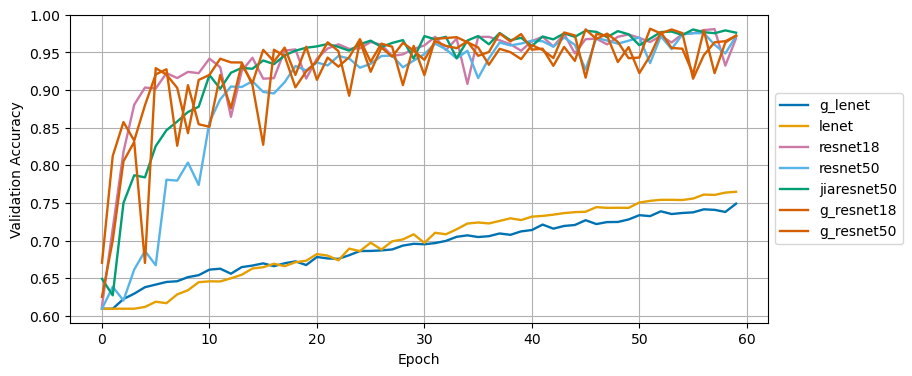

In [11]:
plot_combined_metrics(repeat_model_ids,'val_acc','Validation Accuracy')

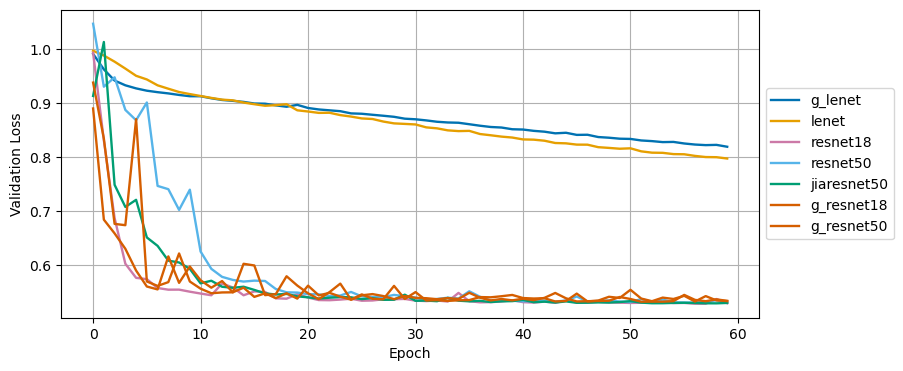

In [12]:
plot_combined_metrics(repeat_model_ids,'val_loss','Validation Loss')

## Predictions on DESI dataset

In [13]:
model_ids = ['resnet18_cut_dataset_repeat',
             'resnet50_cut_dataset_repeat',
            'jiaresnet50_cut_dataset_repeat',
            'g_resnet18_cut_dataset_repeat',
            #'g_resnet50_cut_dataset_repeat',
             'g_resnet18_old_cut_dataset_repeat']

repeat_metrics = get_predict_results_runs(model_ids,5,METRICS_PATH)
repeat_metrics.head(6)

Model,ACW,CW,Other,C Viol
resnet18,10048 (1.0%) ± 1521,8671 (0.9%) ± 1538,979904 (98.0%) ± 3043,10.18 ± 3.78
resnet50,9913 (1.0%) ± 913,8009 (0.8%) ± 828,980174 (98.0%) ± 1826,14.25 ± 6.61
jiaresnet50,12373 (1.2%) ± 808,12387 (1.2%) ± 802,975254 (97.5%) ± 1616,-0.09 ± 0.64
g_resnet18,11846 (1.2%) ± 5314,13405 (1.3%) ± 2990,976309 (97.6%) ± 10628,-13.11 ± 44.02
g_resnet18_old,12763 (1.3%) ± 5136,12365 (1.2%) ± 6016,974473 (97.4%) ± 10271,3.70 ± 27.71


## Preserving chirality violation of test dataset when predicting

In [14]:
model_ids = ['resnet18_cut_dataset_repeat',
             'resnet50_cut_dataset_repeat',
             'resnet18_cut_dataset_r_repeat',
             'resnet50_cut_dataset_r_repeat',
             'g_resnet18_cut_dataset_repeat',
             'g_resnet50_cut_dataset_repeat',
             'g_resnet18_cut_dataset_c_repeat',
             'g_resnet50_cut_dataset_c_repeat',
             'g_resnet18_cut_dataset_r_repeat',
             'g_resnet50_cut_dataset_r_repeat',
             'g_resnet18_cut_dataset_cr_repeat',
             'g_resnet50_cut_dataset_cr_repeat',
             'jiaresnet50_cut_dataset_repeat',
              'jiaresnet50_cut_dataset_r_repeat'
            ]
chirality_list = [-12,-9,-6,-3,0,3,6,9,12]
cviol_table = get_predict_results_runs_cviol(model_ids,chirality_list,METRICS_PATH)

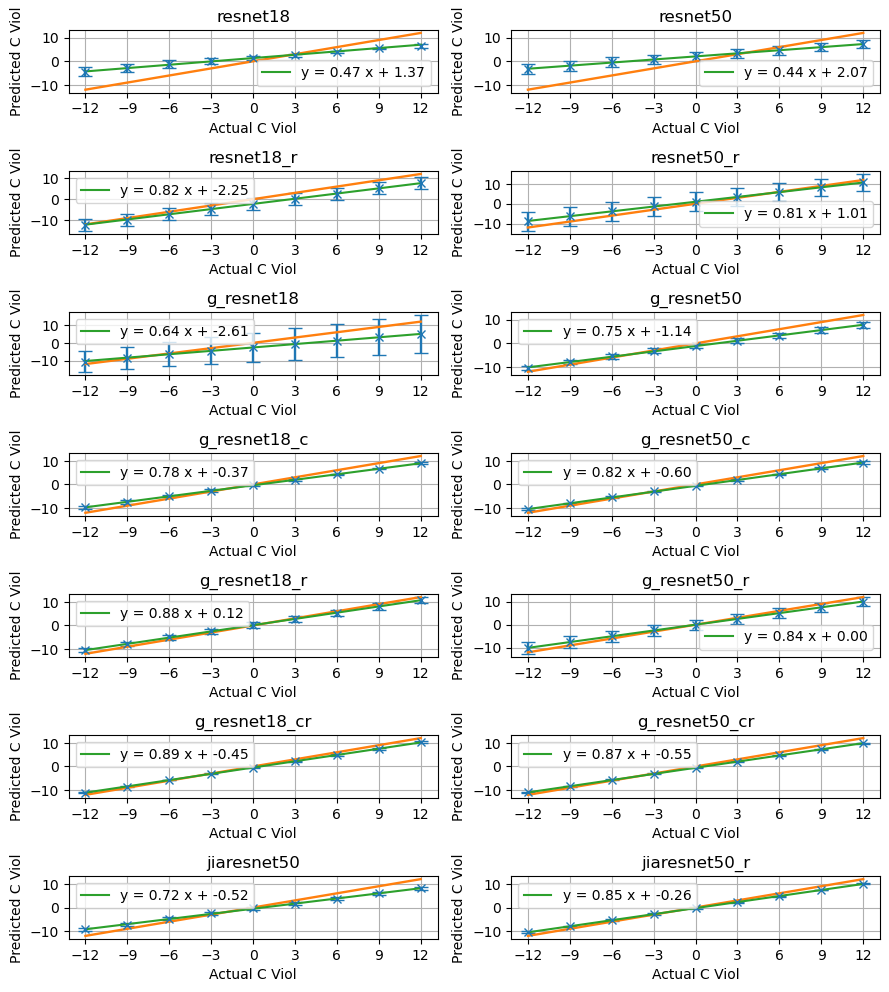

In [15]:
plot_cviols(cviol_table,model_ids,chirality_list)

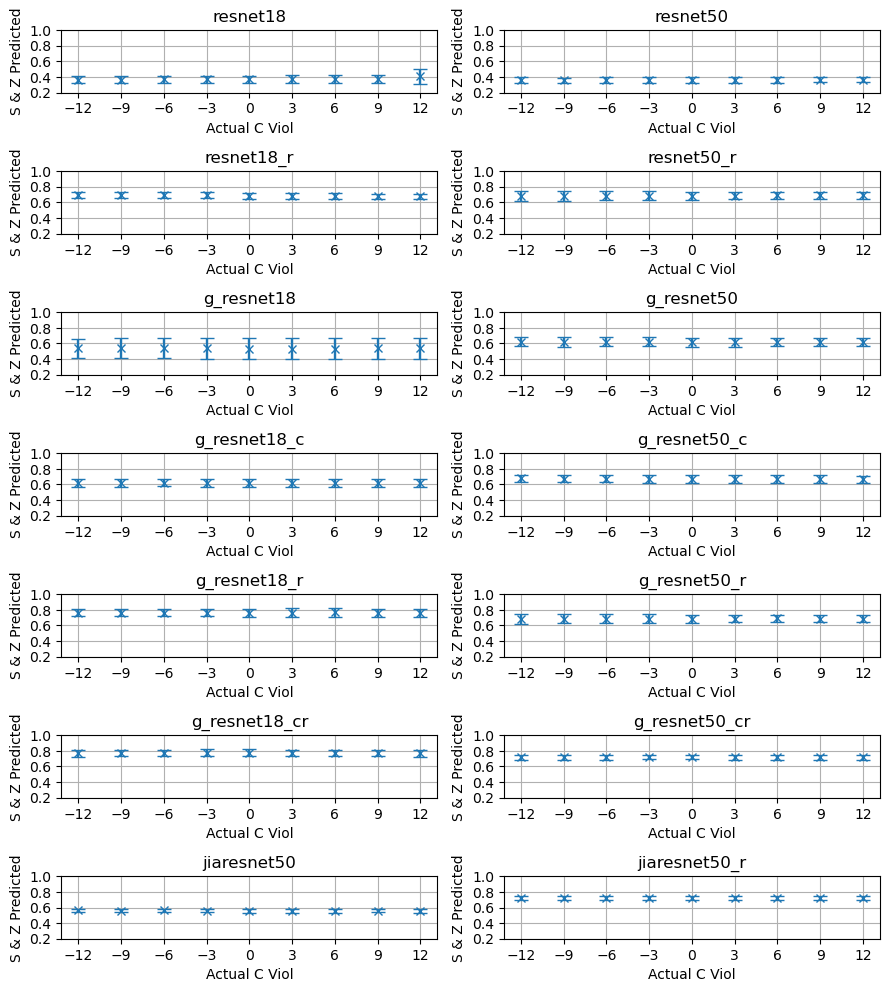

In [16]:
plot_spiral_nums(cviol_table,model_ids,chirality_list)

In [17]:
def plot_vote_fractions(cat,title):
    labels = ["CW","ACW","Other"]
    nice_labels = ["Clockwise Spiral","Anticlockwise Spiral","Other"]
    fig = plt.figure(figsize=(10,3))
    for i, labels in enumerate(labels):
        ax_i = fig.add_subplot(1,3,i+1)
        ax_i.hist(cat[labels],bins=10)
        ax_i.set_title(nice_labels[i])
        ax_i.set_ylim(0,1000)
        ax_i.set_xlim(0,1)
        if i==0:
            ax_i.set_ylabel("Count")
        elif i==1:
            ax_i.set_xlabel("Vote Fractions")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def compare_probabilities(model_ids,c_viol,max_runs=5,dataset_name="cut_test_dataset"):
    for model in model_ids:
            run = 2
            predictions = pd.read_csv(f"{METRICS_PATH}/{model}/version_{run}/{dataset_name}_CVIOL_{c_viol}_predictions.csv", names=['CW','ACW','Other'],on_bad_lines = 'skip').astype('float')
            plot_vote_fractions(predictions,model.removesuffix('_cut_dataset_repeat'))

In [18]:
#compare_probabilities(model_ids,0)